About Dataset

**Context**

It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

**Content**

The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('creditcard.csv')

# Initial inspection
print(df.info())
print(df.describe())
print(df.head())




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

Class
0    284315
1       492
Name: count, dtype: int64


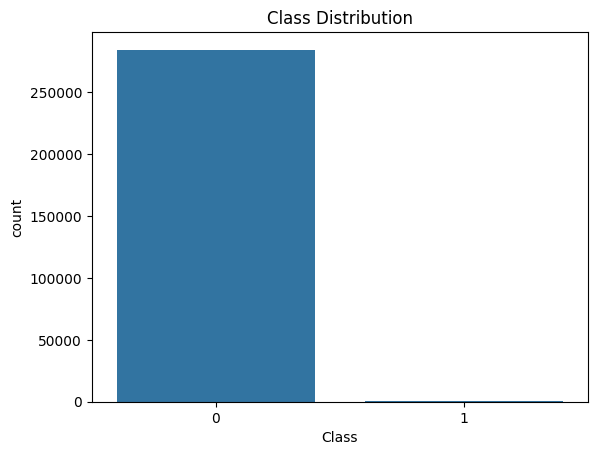

In [7]:
# Check class distribution
print(df['Class'].value_counts())

# Visualize the imbalance
sns.countplot(x='Class', data=df)
plt.title('Class Distribution')
plt.show()

In [ ]:
#Some preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


#Scaling because they have different scales
scaler = StandardScaler()
df['Amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
df['Time'] = scaler.fit_transform(df['Time'].values.reshape(-1, 1))

X = df.drop('Class', axis=1)
y = df['Class']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

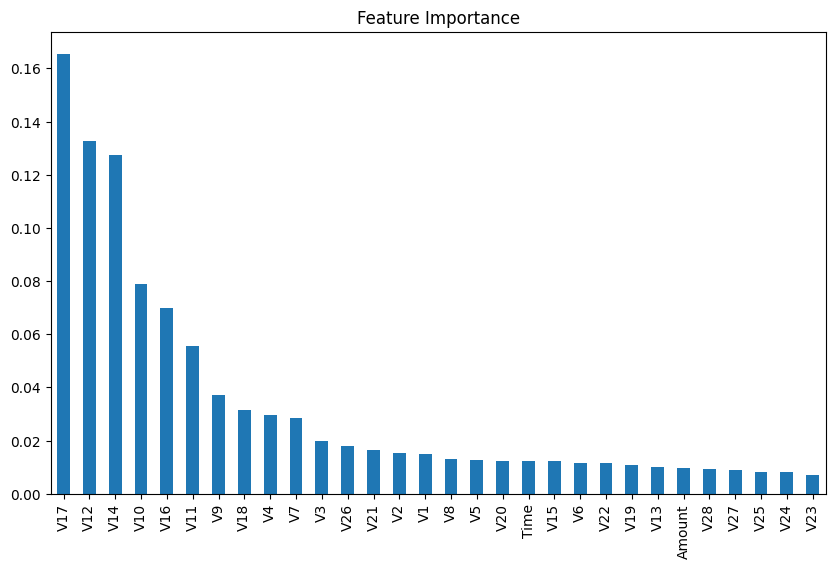

In [ ]:
#Feature engineering
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

feature_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
feature_importances.sort_values(ascending=False).plot(kind='bar', figsize=(10, 6))
plt.title('Feature Importance')
plt.show()


In [14]:
#Evaluation using some baseline models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, roc_auc_score


lr = LogisticRegression(class_weight='balanced', random_state=42)
lr.fit(X_train, y_train)

#Evaluating on validation set
y_pred_lr = lr.predict(X_val)
print("Logistic Regression Results:")
print(classification_report(y_val, y_pred_lr))
print("AUPRC:", roc_auc_score(y_val, lr.predict_proba(X_val)[:, 1]))


dt = DecisionTreeClassifier(class_weight='balanced', random_state=42)
dt.fit(X_train, y_train)

y_pred_dt = dt.predict(X_val)
print("Decision Tree Results:")
print(classification_report(y_val, y_pred_dt))
print("AUPRC:", roc_auc_score(y_val, dt.predict_proba(X_val)[:, 1]))

Logistic Regression Results:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     42647
           1       0.07      0.88      0.12        74

    accuracy                           0.98     42721
   macro avg       0.53      0.93      0.56     42721
weighted avg       1.00      0.98      0.99     42721

AUPRC: 0.9683501706973464
Decision Tree Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     42647
           1       0.81      0.65      0.72        74

    accuracy                           1.00     42721
   macro avg       0.91      0.82      0.86     42721
weighted avg       1.00      1.00      1.00     42721

AUPRC: 0.8241953586291992


Both models have not performed well, although Decision Tree has better balance between precision and recall.

Need to address class imbalance

Synthetic Minority Over-sampling Technique:
SMOTE works by artificially generating new samples  for the minority class, thereby balancing the dataset. This helps improve the model's ability to learn patterns from the minority class without simply duplicating existing data.

In [ ]:
#Using SMOTE
from imblearn.over_sampling import SMOTE


smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Train Logistic Regression with SMOTE
lr_smote = LogisticRegression(class_weight='balanced', random_state=42)
lr_smote.fit(X_train_smote, y_train_smote)


y_pred_lr_smote = lr_smote.predict(X_val)
print("Logistic Regression with SMOTE Results:")
print(classification_report(y_val, y_pred_lr_smote))
print("AUPRC:", roc_auc_score(y_val, lr.predict_proba(X_val)[:, 1]))

dt_smote = DecisionTreeClassifier(class_weight='balanced', random_state=42)
dt_smote.fit(X_train_smote, y_train_smote)


y_pred_dt_smote = lr_smote.predict(X_val)
print("Decision Tree with SMOTE Results:")
print(classification_report(y_val, y_pred_dt_smote))
print("AUPRC:", roc_auc_score(y_val, dt.predict_proba(X_val)[:, 1]))



Logistic Regression with SMOTE Results:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     42647
           1       0.06      0.88      0.12        74

    accuracy                           0.98     42721
   macro avg       0.53      0.93      0.55     42721
weighted avg       1.00      0.98      0.99     42721

AUPRC: 0.9683501706973464
Decision Tree with SMOTE Results:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     42647
           1       0.06      0.88      0.12        74

    accuracy                           0.98     42721
   macro avg       0.53      0.93      0.55     42721
weighted avg       1.00      0.98      0.99     42721

AUPRC: 0.8241953586291992


SMOTE made no significant improvements to Logistic Regression model, and in fact it made the Decision Tree Classifier much worse.
Time to experiment with a more advanced model.

In [ ]:
from xgboost import XGBClassifier

#Training XGBoost with SMOTE
xgb = XGBClassifier(scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1]), random_state=42)
xgb.fit(X_train_smote, y_train_smote)


y_pred_xgb = xgb.predict(X_val)
print("XGBoost with SMOTE Results:")
print(classification_report(y_val, y_pred_xgb))
print("AUPRC:", roc_auc_score(y_val, xgb.predict_proba(X_val)[:, 1]))

XGBoost with SMOTE Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     42647
           1       0.56      0.84      0.67        74

    accuracy                           1.00     42721
   macro avg       0.78      0.92      0.84     42721
weighted avg       1.00      1.00      1.00     42721

AUPRC: 0.9662759460283319


Significant improvements have been made, can try to optimize hyperparameters for even better performance.


In [ ]:
from sklearn.model_selection import GridSearchCV


param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [50, 100, 200],
    'subsample': [0.8, 1.0]
}


grid_search = GridSearchCV(estimator=XGBClassifier(scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1]), random_state=42),
                           param_grid=param_grid,
                           scoring='f1',
                           cv=3,
                           verbose=2)
grid_search.fit(X_train_smote, y_train_smote)

print("Best Parameters:", grid_search.best_params_)
print("Best F1-Score:", grid_search.best_score_)

Fitting 3 folds for each of 54 candidates, totalling 162 fits
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.6s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.7s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.6s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.6s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.6s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.6s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   1.0s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   1.0s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   1.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   1.3s
[CV]

In [ ]:
# Re-train XGBoost with best parameters
best_xgb = XGBClassifier(
    learning_rate=0.3,
    max_depth=7,
    n_estimators=200,
    subsample=0.8,
    scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1]),
    random_state=42
)
best_xgb.fit(X_train_smote, y_train_smote)

y_pred_val = best_xgb.predict(X_val)
print("Validation Results with Best Parameters:")
print(classification_report(y_val, y_pred_val))
print("AUPRC:", roc_auc_score(y_val, best_xgb.predict_proba(X_val)[:, 1]))


Validation Results with Best Parameters:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     42647
           1       0.68      0.82      0.74        74

    accuracy                           1.00     42721
   macro avg       0.84      0.91      0.87     42721
weighted avg       1.00      1.00      1.00     42721

AUPRC: 0.9646581711967319


Slight improvement seen in results, maybe feature selection will help

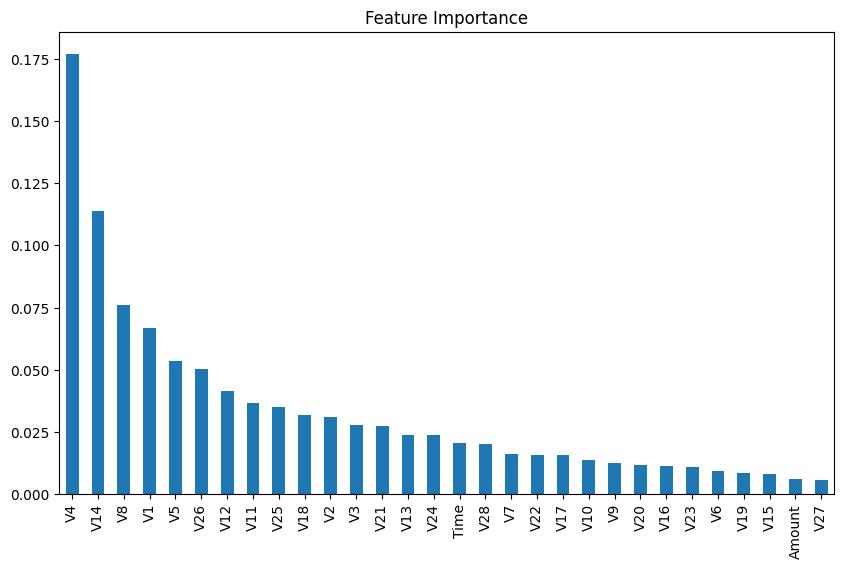

Selected Features: Index(['V4', 'V14', 'V8', 'V1', 'V5', 'V26', 'V12', 'V11', 'V25', 'V18', 'V2',
       'V3', 'V21', 'V13', 'V24', 'Time', 'V28', 'V7', 'V22', 'V17'],
      dtype='object')


In [27]:

feature_importances = pd.Series(best_xgb.feature_importances_, index=X_train_smote.columns)
feature_importances.sort_values(ascending=False).plot(kind='bar', figsize=(10, 6))
plt.title('Feature Importance')
plt.show()

top_features = feature_importances.sort_values(ascending=False).head(20).index

#Reducing the dataset to only include top features
X_train_reduced = X_train_smote[top_features]
X_val_reduced = X_val[top_features]

print("Selected Features:", top_features)

In [ ]:
#Retrain XGBoost with reduced features
reduced_xgb = XGBClassifier(
    learning_rate=0.3,
    max_depth=7,
    n_estimators=200,
    subsample=0.8,
    scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1]),
    random_state=42,
   
)
reduced_xgb.fit(X_train_reduced, y_train_smote)


y_pred_reduced = reduced_xgb.predict(X_val_reduced)
print("Validation Results with Reduced Features:")
print(classification_report(y_val, y_pred_reduced))
print("AUPRC:", roc_auc_score(y_val, reduced_xgb.predict_proba(X_val_reduced)[:, 1]))

Validation Results with Reduced Features:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     42647
           1       0.68      0.81      0.74        74

    accuracy                           1.00     42721
   macro avg       0.84      0.91      0.87     42721
weighted avg       1.00      1.00      1.00     42721

AUPRC: 0.9617665828653705


No improvements seen using feature selection, reducing the number of features makes the performance worse


In [ ]:
#Trying alternative models
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMClassifier


param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [15, 31, 63],
    'max_depth': [5, 7, 10],
    'n_estimators': [100, 200, 500],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'scale_pos_weight': [len(y_train[y_train==0]) / len(y_train[y_train==1])],
    'min_child_samples': [10, 20, 30]
}


random_search = RandomizedSearchCV(
    estimator=LGBMClassifier(random_state=42),
    param_distributions=param_grid,
    scoring='f1',
    n_iter=50,
    cv=3,
    verbose=2,
    random_state=42
)
random_search.fit(X_train_smote, y_train_smote)

print("Best Parameters:", random_search.best_params_)
print("Best F1-Score:", random_search.best_score_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[LightGBM] [Info] Number of positive: 132680, number of negative: 132680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051560 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 265360, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=7, min_child_samples=30, n_estimators=200, num_leaves=15, scale_pos_weight=578.546511627907, subsample=0.8; total time=   2.7s
[LightGBM] [Info] Number of positive: 132680, number of negative: 132680
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026125 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points

In [ ]:
from lightgbm import LGBMClassifier

# Train LightGBM
lgb = LGBMClassifier(
    learning_rate=0.05,
    num_leaves=31,
    min_child_samples=30,
    max_depth=7,
    n_estimators=500,
    subsample=0.6,
    scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1]),
    random_state=42
)
lgb.fit(X_train_smote, y_train_smote)


y_pred_lgb = lgb.predict(X_val)
print("Validation Results with LightGBM:")
print(classification_report(y_val, y_pred_lgb))
print("AUPRC:", roc_auc_score(y_val, lgb.predict_proba(X_val)[:, 1]))


[LightGBM] [Info] Number of positive: 199020, number of negative: 199020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020133 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 398040, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Validation Results with LightGBM:
              precision    recall  f1-score   support

           0       1.00      0.93      0.97     42647
           1       0.02      0.82      0.04        74

    accuracy                           0.93     42721
   macro avg       0.51      0.88      0.50     42721
weighted avg       1.00      0.93      0.96     42721

AUPRC: 0.9082852695826645


Very poor performance. Lets try catboost

In [ ]:
from catboost import CatBoostClassifier

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [5, 7, 10],
    'iterations': [200, 500, 1000],  
    'l2_leaf_reg': [1, 3, 5],       
    'bagging_temperature': [0, 1, 2],  
    'scale_pos_weight': [len(y_train[y_train==0]) / len(y_train[y_train==1])]  
}

random_search_cat = RandomizedSearchCV(
    estimator= CatBoostClassifier(random_state=42, verbose = 0),
    param_distributions=param_grid,
    scoring='f1', 
    n_iter=50,     
    cv=3,          
    verbose=2,
    random_state=42
)

random_search_cat.fit(
    X_train_smote, y_train_smote,
    eval_set=(X_val, y_val),  
    early_stopping_rounds=10,  
    verbose=True
)


print("Best Parameters:", random_search.best_params_)
print("Best F1-Score:", random_search.best_score_)


<frozen importlib._bootstrap>:488: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216 from C header, got 232 from PyObject


Fitting 3 folds for each of 50 candidates, totalling 150 fits
0:	learn: 0.6525354	test: 0.6847073	best: 0.6847073 (0)	total: 178ms	remaining: 2m 57s
1:	learn: 0.6187842	test: 0.6820159	best: 0.6820159 (1)	total: 210ms	remaining: 1m 45s
2:	learn: 0.5865823	test: 0.6798147	best: 0.6798147 (2)	total: 245ms	remaining: 1m 21s
3:	learn: 0.5507986	test: 0.6733430	best: 0.6733430 (3)	total: 281ms	remaining: 1m 9s
4:	learn: 0.5198926	test: 0.6715509	best: 0.6715509 (4)	total: 316ms	remaining: 1m 2s
5:	learn: 0.4936509	test: 0.6707553	best: 0.6707553 (5)	total: 347ms	remaining: 57.5s
6:	learn: 0.4675229	test: 0.6725221	best: 0.6707553 (5)	total: 380ms	remaining: 54s
7:	learn: 0.4450839	test: 0.6713108	best: 0.6707553 (5)	total: 416ms	remaining: 51.6s
8:	learn: 0.4203650	test: 0.6730661	best: 0.6707553 (5)	total: 453ms	remaining: 49.9s
9:	learn: 0.3947915	test: 0.6731218	best: 0.6707553 (5)	total: 488ms	remaining: 48.3s
10:	learn: 0.3728368	test: 0.6756172	best: 0.6707553 (5)	total: 521ms	remaini

In [ ]:
cbC = CatBoostClassifier(
    learning_rate=0.05,
    num_leaves=31,
    min_child_samples=30,
    max_depth=7,
    n_estimators=500,
    subsample=0.6,
    scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1]),
    random_state=42
)
cbC.fit(X_train_smote, y_train_smote)


y_pred_cbC = cbC.predict(X_val)
print("Validation Results with CatBoost:")
print(classification_report(y_val, y_pred_lgb))
print("AUPRC:", roc_auc_score(y_val, cbC.predict_proba(X_val)[:, 1]))

0:	learn: 0.5044801	total: 52.9ms	remaining: 26.4s
1:	learn: 0.3815401	total: 104ms	remaining: 26s
2:	learn: 0.2817845	total: 157ms	remaining: 26s
3:	learn: 0.2044349	total: 207ms	remaining: 25.7s
4:	learn: 0.1457342	total: 261ms	remaining: 25.8s
5:	learn: 0.1153476	total: 319ms	remaining: 26.3s
6:	learn: 0.0889652	total: 373ms	remaining: 26.3s
7:	learn: 0.0688028	total: 430ms	remaining: 26.4s
8:	learn: 0.0516752	total: 483ms	remaining: 26.4s
9:	learn: 0.0410641	total: 544ms	remaining: 26.6s
10:	learn: 0.0317022	total: 601ms	remaining: 26.7s
11:	learn: 0.0261266	total: 655ms	remaining: 26.6s
12:	learn: 0.0217496	total: 709ms	remaining: 26.6s
13:	learn: 0.0184288	total: 765ms	remaining: 26.6s
14:	learn: 0.0156893	total: 817ms	remaining: 26.4s
15:	learn: 0.0135017	total: 871ms	remaining: 26.4s
16:	learn: 0.0120139	total: 922ms	remaining: 26.2s
17:	learn: 0.0106589	total: 977ms	remaining: 26.2s
18:	learn: 0.0096266	total: 1.03s	remaining: 26s
19:	learn: 0.0088113	total: 1.08s	remaining: 2

In [ ]:
from imblearn.over_sampling import ADASYN

#Applying ADASYN (Adaptive Synthetic Sampling Approach) to balance the dataset
adasyn = ADASYN(random_state=42)
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train, y_train)

xgb_adasyn = XGBClassifier(
    learning_rate=0.3,
    max_depth=7,
    n_estimators=200,
    subsample=0.8,
    scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1]),
    random_state=42
)
xgb_adasyn.fit(X_train_adasyn, y_train_adasyn)


y_pred_adasyn = xgb_adasyn.predict(X_val)
print("Validation Results with XGBoost and ADASYN:")
print(classification_report(y_val, y_pred_adasyn))
print("AUPRC:", roc_auc_score(y_val, xgb_adasyn.predict_proba(X_val)[:, 1]))


Validation Results with XGBoost and ADASYN:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     42647
           1       0.64      0.81      0.71        74

    accuracy                           1.00     42721
   macro avg       0.82      0.91      0.86     42721
weighted avg       1.00      1.00      1.00     42721

AUPRC: 0.9460970924731564


In [ ]:
from imblearn.combine import SMOTEENN

#SMOTE + ENN (Edited Nearest Neighbors)
smote_enn = SMOTEENN(random_state=42)
X_train_hybrid, y_train_hybrid = smote_enn.fit_resample(X_train, y_train)


xgb_hybrid = XGBClassifier(
    learning_rate=0.3,
    max_depth=7,
    n_estimators=200,
    subsample=0.8,
    scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1]),
    random_state=42
)
xgb_hybrid.fit(X_train_hybrid, y_train_hybrid)


y_pred_hybrid = xgb_hybrid.predict(X_val)
print("Validation Results with Hybrid Resampling:")
print(classification_report(y_val, y_pred_hybrid))
print("AUPRC:", roc_auc_score(y_val, xgb_hybrid.predict_proba(X_val)[:, 1]))

Validation Results with Hybrid Resampling:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     42647
           1       0.55      0.81      0.66        74

    accuracy                           1.00     42721
   macro avg       0.78      0.90      0.83     42721
weighted avg       1.00      1.00      1.00     42721

AUPRC: 0.9583947795193604


No improvements over previous models, for now the best performing model is XGBoost with SMOTE. Will try more advanced methods in the future